# Redes Neuronales Artificiales
## Trabajo Práctico 1
### Agustin de Otazua - 277/21

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import requests

plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
def bias_add(V):
    bias = -np.ones( (len(V),1) )
    return np.concatenate((V,bias), axis=1).copy()

def bias_sub(V):
    return V[:,:-1].copy()

def sigmoid(x):
#     if x > 5:
#         res = 1
#     elif x < -5:
#         res = 0
#     else:
#         res = 1/(1 + np.exp(-x))
#     return res
    return 1/(1 + np.exp(-x))

def standardize(X, individual_std = True):
    if individual_std:
        return (X-X.mean(axis=0))/X.std(axis=0)
    else:
        return (X-X.mean(axis=0))/X.std()

def val_train_test_split(X, Z):
    L = len(X)
    indexes = np.random.permutation(L)
    val = indexes[:int(0.25*L)]
    trn = indexes[int(0.25*L):int(0.9*L)]
    tst = indexes[int(0.9*L):]
    return X[val], X[trn], X[tst], Z[val], Z[trn], Z[tst]

### Parte 1: Diagnóstico de cáncer de mamas

#### Descripción

Se tiene un dataset de pacientes, donde en cada uno están definidos diez atributos médicos y una variable binaria que indica el diagnóstico sobre si tiene cáncer de mama (1) o no (0). 

El objetivo es entrenar una red neuronal artificial que sepa predecir el diagnóstico de cada paciente en base a esos atributos.

#### Creo la clase de un clasificador binario basado en un perceptrón multicapa.

* Uso activaciones *tanh* para las capas internas y una *sigmoid* para la capa de salida.

* Las listas de *W* y *dW* quedan con longitud una unidad menor al número de capas ya que no utilizo las matrices vacías de cada una.

In [15]:
class MLP_BinaryClassifier:
    def __init__(self, sizes):
        self.S = sizes
        self.L = len(sizes)
        self.Y = [np.zeros((1, sizes[i]+1)) for i in range(self.L)]
        self.W = [np.random.normal( 0, 0.5, (sizes[i]+1, sizes[i+1])) for i in range(self.L-1)]
        self.dW = [np.zeros((sizes[i]+1, sizes[i+1])) for i in range(self.L-1)]
        self.errors = []
    
    def activation(self, X):
        Y_act = X.reshape(1,self.S[0])    # vector activacion
        for i in range(self.L - 2):
            self.Y[i] = bias_add(Y_act)
            Y_act = np.tanh(np.dot(self.Y[i], self.W[i]))  
        self.Y[-2] = bias_add(Y_act)
        Y_act = np.array([[sigmoid(np.dot(self.Y[-2], self.W[-1])[0,0])]] )   
        self.Y[-1] = Y_act
        return Y_act
    
    def correction(self, Z):
        E = Z - self.Y[-1]
        #dY = 1-np.square(self.Y[-1]) #ajuste tanh
        dY = self.Y[-1] - np.square(self.Y[-1])  #ajuste sigmoide
        D = E*dY
        for i in range(self.L-2, -1, -1):
            self.dW[i] = np.dot(self.Y[i].T, D)
            E = np.dot(D, self.W[i].T)
            dY = 1-np.square(self.Y[i])
            D = bias_sub(E*dY)  
    
    def adaptation(self, lr):
        for i in range(self.L-1):
            self.W[i] += lr * self.dW[i]
        
    def predict(self, X):
        predictions = np.zeros((len(X), 1))
        for i in range(len(X)):
            predictions[i] = self.activation(X[i]).reshape(1)
            if predictions[i, 0] > 0.5:
                predictions[i, 0] = 1
            else:
                predictions[i, 0] = 0
        return predictions   
    
    def fit(self, X_trn, Z_trn, X_val = None, Z_val = None, lr = 0.1, error_lim = 0.05, max_epochs = 300, print_epochs = False):
        
        Z_trn = Z_trn.reshape(len(Z_trn), 1)
        
        if (X_val is None) or (Z_val is None):
            X_val = X_trn
            Z_val = Z_trn            
            
        Z_val = Z_val.reshape(len(Z_val), 1)
        
        epochs = 0
        error = np.inf
        epoch_errors = np.zeros(len(X_trn))
        
        while(error > error_lim and epochs < max_epochs):
            indexes = np.random.permutation(len(X_trn))
            for i in indexes:
                self.activation(X_trn[i])
                self.correction(Z_trn[i])
                self.adaptation(lr)
                predictions = self.predict(X_val)
                epoch_errors[i] = np.mean(np.sum(np.square(Z_val-predictions), axis=1)) 
                
            self.errors.append(epoch_errors.mean()) 
            #self.errors += [np.mean(np.sum(np.square(Zh-predictions), axis=1))] 
            epochs += 1
            
        if print_epochs:
            print("epoch = {}".format(epochs))
            
    def accuracy(self, X, Z):
        return (self.predict(X) == Z.reshape(len(Z), 1)).mean()

#### Cargo los datos completos.

In [24]:
# data = np.loadtxt('tp1_ej1_training.csv' , delimiter = ',' )
r = requests.get("https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp1_ej1_training.csv")
data = np.loadtxt(r.iter_lines() , delimiter = ",")
data.shape

(410, 11)

#### Divido los datos entre diagnóstico (variable a predecir) y los atributos (covariables explicativas).

In [8]:
diagnostico = data[:,0]
atributos = data[:,1:]

#### Busco una arquitectura apropiada

Dada una lista de arquitecturas posibles, con cada arquitectura en formato lista ($[10,3,1]$ por ej.), busco la que de un accuracy promedio mayor luego de correr una cantidad **num_models** de modelos por cada arquitectura.

Consideraciones importantes:

* El conjunto de validación será el 25% de los datos totales, el de entrenamiento un 65% y el de testeo un 10%. 

* Los distintos conjuntos son estandarizados restándole la media y dividiendo por la desviación estándar de cada variable por separado.

* Uso una validacion de estilo *hold-out*. 

* Es importante que el modelo tenga un accuracy medio mayor a 0.5, ya que en caso contrario sería mejor clasificar 1 o 0 al azar.

In [12]:
def elegir_arquitectura_clasificador(X, Z, arquitecturas, num_models = 4, lr = 0.1, error_lim = 0.05, max_epochs = 100):
    """Devuelve la arquitectura que da un accuracy promedio mayor"""
    arq_elegida = arquitecturas[0]
    accuracy_max = 0
    
    for arq in arquitecturas:
        
        accuracy_list = np.array([])
        
        for i in range(num_models):
            X_val, X_trn, X_tst, Z_val, Z_trn, Z_tst = val_train_test_split(X, Z)
            X_val_s = standardize(X_val)
            X_trn_s = standardize(X_trn)
            X_tst_s = standardize(X_tst)
            clasificador = MLP_BinaryClassifier(arq)
            clasificador.fit(X_trn_s, Z_trn, X_val_s, Z_val, lr, error_lim, max_epochs)
            acc = clasificador.accuracy(X_tst_s, Z_tst)
            accuracy_list = np.append(accuracy_list, acc)
            
        accuracy_prom = accuracy_list.mean()
        
        if accuracy_prom > accuracy_max:
            arq_elegida = arq
            accuracy_max = accuracy_prom
            
        print("accuracy media de {} : {}".format(arq, accuracy_prom)) 
        
    print("arquitectura elegida: {}".format(arq_elegida))  
    
    return arq_elegida

In [316]:
%%time
arquitecturas = [[10, 9, 1], [10, 8, 1], [10, 8, 6, 1], [10, 6, 5, 1], [10, 6, 3, 1], [10, 7, 5, 3, 1]]
arq_elegida = elegir_arquitectura_clasificador(atributos, diagnostico, arquitecturas, num_models = 4)

accuracy media de [10, 9, 1] : 0.7317073170731707
accuracy media de [10, 8, 1] : 0.6036585365853658
accuracy media de [10, 8, 6, 1] : 0.6585365853658537
accuracy media de [10, 6, 5, 1] : 0.6280487804878049
accuracy media de [10, 6, 3, 1] : 0.6463414634146343
accuracy media de [10, 7, 5, 3, 1] : 0.6585365853658537
arquitectura elegida: [10, 9, 1]
Wall time: 5min 28s


In [16]:
%%time
arquitecturas = [[10, 15, 1]]
arq_elegida = elegir_arquitectura_clasificador(atributos, diagnostico, arquitecturas, num_models = 1, max_epochs = 100)

accuracy media de [10, 15, 1] : 0.7317073170731707
arquitectura elegida: [10, 15, 1]
Wall time: 4min 5s


Por lo obtenido, la arquitectura a seleccionar será $[10, 9, 1]$.

Entreno el modelo con todos los datos del dataset.

In [325]:
atributos_s = standardize(atributos)
clasificador = MLP_BinaryClassifier(arq_elegida)
clasificador.fit(atributos_s, diagnostico, lr = 0.1, error_lim = 0.1, max_iters = 3000)

Para testearlo, se debe cambiar *atributos_s* y *diagnostico* del siguiente código por los datos de testeo. Primero estandarizar con *stardardize* los atributos.

In [327]:
clasificador.accuracy(atributos_s, diagnostico)

0.8195121951219512

### Parte 2: Eficiencia Energética

#### Descripción

Se tiene un dataset de edificios, donde en cada uno están definidas 8 características edilicias (atributos) y dos variables que indican la cantidad de carga energética que necesita la calefacción y la refrigeración. 

El objetivo es entrenar una red neuronal artificial que sepa predecir dichas cargas energéticas en base a esos atributos.

In [25]:
class MLP_Regressor:
    def __init__(self, sizes):
        self.S = sizes
        self.L = len(sizes)
        self.Y = [np.zeros((1, sizes[i]+1)) for i in range(self.L)]
        self.W = [np.random.normal( 0, 0.5, (sizes[i]+1, sizes[i+1])) for i in range(self.L-1)]
        self.dW = [np.zeros((sizes[i]+1, sizes[i+1])) for i in range(self.L-1)]
        self.errors = []
    
    def activation(self, X):
        Y_act = X.reshape(1,self.S[0])    # vector activacion
        for i in range(self.L - 2):
            self.Y[i] = bias_add(Y_act)
            Y_act = np.tanh(np.dot(self.Y[i], self.W[i]))
        self.Y[-2] = bias_add(Y_act)
        Y_act = np.dot(self.Y[-2], self.W[-1])
        self.Y[-1] = Y_act
        return Y_act
    
    def correction(self, Z):
        E = Z - self.Y[-1]
        D = E
        for i in range(self.L-2, -1, -1):
            self.dW[i] = np.dot(self.Y[i].T, D)
            E = np.dot(D, self.W[i].T)
            dY = 1-np.square(self.Y[i])
            D = bias_sub(E*dY)  
    
    def adaptation(self, lr):
        for i in range(self.L-1):
            self.W[i] += lr * self.dW[i]
            
    def predict(self, X):
        predictions = np.zeros((len(X), self.S[-1]))
        for i in range(len(X)):
            if X.shape[1] == 1:
                predictions[i] = self.activation(X[i]).reshape(1)
            else:
                predictions[i] = self.activation(X[i])
        return np.array(predictions)    
    
    def estimation(self, X, Z):
        predictions = self.predict(X)
        return np.mean(np.sum(np.square(Z.reshape(len(Z), self.S[-1])-predictions), axis=1))
    
    def fit(self, X_trn, Z_trn, X_val = None, Z_val = None, lr = 0.1, error_lim = 0.05, max_epochs = 300, print_iters = False):
        if Z_trn.shape[1] == 1:
            Z_trn = Z_trn.reshape(len(Z_trn), 1)
        if (X_val is None) or (Z_val is None):
            X_val = X_trn
            Z_val = Z_trn
        if Z_trn.shape[1] == 1:
            Z_val = Z_val.reshape(len(Z_val), 1)
            
        error = np.inf
        epochs = 0
        epoch_errors = np.zeros(len(X_trn))
        
        while(error > error_lim and epochs < max_epochs):
            indexes = np.random.permutation(len(X_trn))
            for i in indexes:
                i = np.random.choice(len(X_trn))
                self.activation(X_trn[i])
                self.correction(Z_trn[i])
                self.adaptation(lr)
                predictions = self.predict(X_val)
                epoch_errors[i] = np.mean(np.sum(np.square(Z_val-predictions), axis=1))
                
            self.errors.append(epoch_errors.mean())
            epochs += 1
            
        if print_iters:
            print("epochs = {}".format(iters))
                   

#### Cargo los datos completos.

In [18]:
# dataEE = np.loadtxt('tp1_ej2_training.csv' , delimiter = ',' )
r = requests.get("https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp1_ej2_training.csv")
dataEE = np.loadtxt(r.iter_lines() , delimiter = ",")
dataEE

array([[7.100e-01, 7.105e+02, 2.695e+02, ..., 1.000e+00, 1.075e+01,
        1.427e+01],
       [7.900e-01, 6.370e+02, 3.430e+02, ..., 2.000e+00, 3.898e+01,
        4.597e+01],
       [6.600e-01, 7.595e+02, 3.185e+02, ..., 1.000e+00, 1.169e+01,
        1.372e+01],
       ...,
       [6.600e-01, 7.595e+02, 3.185e+02, ..., 4.000e+00, 1.529e+01,
        1.782e+01],
       [9.800e-01, 5.145e+02, 2.940e+02, ..., 5.000e+00, 2.858e+01,
        2.977e+01],
       [8.200e-01, 6.125e+02, 3.185e+02, ..., 4.000e+00, 2.543e+01,
        2.876e+01]])

In [19]:
cargasEE = dataEE[:,-2:]
atributosEE = dataEE[:,:-2]

#### Busco una arquitectura apropiada

Dada una lista de arquitecturas posibles, con cada arquitectura en formato lista ($[10,3,1]$ por ej.), busco la que de un accuracy promedio mayor luego de correr una cantidad **num_models** de modelos por cada arquitectura.

Consideraciones importantes:

* El conjunto de validación será el 25% de los datos totales, el de entrenamiento un 65% y el de testeo un 10%. 

* Los distintos conjuntos son estandarizados restándole la media de cada variable por separado y dividiendo por la desviación estándar de todo el dataset.

* Uso una validacion de estilo *hold-out*. 


In [26]:
def elegir_arquitectura_regresor(X, Z, arquitecturas, num_models = 4, lr = 0.1, error_lim = 0.05, max_epochs = 100):
    """Devuelve la arquitectura que da un error promedio mayor"""
    arq_elegida = arquitecturas[0]
    error_min = np.inf
    
    for arq in arquitecturas:
        
        error_list = np.array([])
        
        for i in range(num_models):
            X_val, X_trn, X_tst, Z_val, Z_trn, Z_tst = val_train_test_split(X, Z)
            X_val_s = standardize(X_val, individual_std = False)
            X_trn_s = standardize(X_trn, individual_std = False)
            X_tst_s = standardize(X_tst, individual_std = False)
            regresor = MLP_Regressor(arq)
            regresor.fit(X_trn_s, Z_trn, X_val_s, Z_val, lr, error_lim, max_epochs)
            acc = regresor.estimation(X_tst_s, Z_tst)
            error_list = np.append(error_list, acc)
            
        error_prom = error_list.mean()
        
        if error_prom < error_min:
            arq_elegida = arq
            error_min = error_prom
            
        print("error medio de {} : {}".format(arq, error_prom)) 
        
    print("arquitectura elegida: {}".format(arq_elegida))  
    
    return arq_elegida

In [27]:
%%time
arquitecturas = [[8, 6, 2],[8, 5, 2], [8, 10, 2], [8, 10, 4, 2]]
arq_elegida = elegir_arquitectura_regresor(atributosEE, cargasEE, arquitecturas, num_models = 1)

error medio de [8, 6, 2] : 111.47370034008242
error medio de [8, 5, 2] : 119.725143016105
error medio de [8, 10, 2] : 30.46652508283814
error medio de [8, 10, 4, 2] : 198.0128807894593
arquitectura elegida: [8, 10, 2]
Wall time: 6min 44s


Por lo obtenido, la arquitectura a seleccionar será $[8, 5, 2]$.

Entreno el modelo con todos los datos del dataset.

In [23]:
%%time
arquitecturas = [[8, 10, 2]]
arq_elegida = elegir_arquitectura_regresor(atributosEE, cargasEE, arquitecturas, num_models = 1)

error medio de [8, 10, 2] : 133.35394123207942
arquitectura elegida: [8, 10, 2]
Wall time: 4min 56s


In [18]:
atributosEE_s = standardize(atributosEE, individual_std = False)
regresor = MLP_Regressor(arq_elegida)
regresor.fit(atributosEE_s, cargasEE, lr = 0.1, error_lim = 0.1, max_iters = 3000)

Para testearlo, se debe cambiar *atributosEE_s* y *cargasEE* del siguiente código por los datos de testeo. Primero estandarizar con *stardardize* los atributos.

In [19]:
regresor.estimation(atributosEE_s, cargasEE)

313.9107380052465

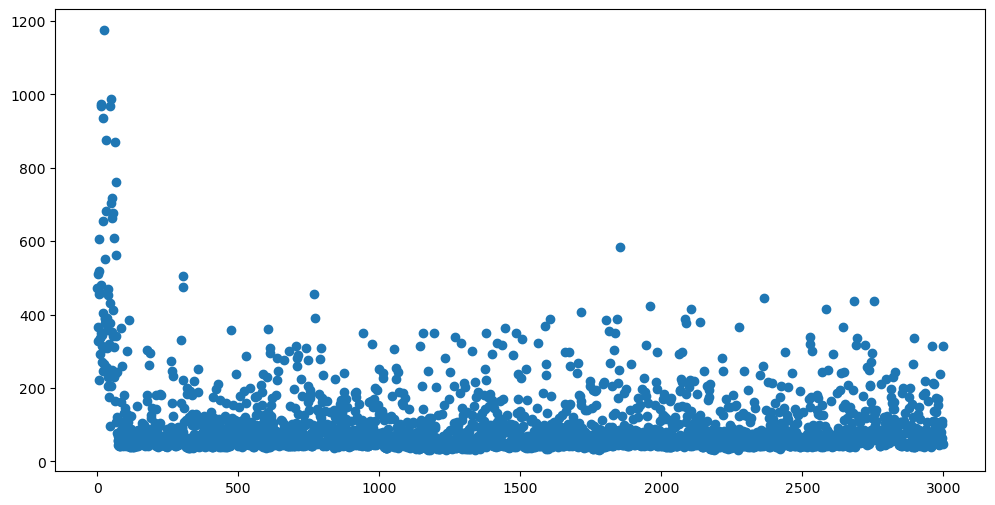

In [22]:
plt.scatter(range(len(regresor.errors)), regresor.errors)